<a href="https://colab.research.google.com/github/ramakant-BIM/Banking-Dataset-Predictive-Analytics-for-Term-Deposit-Subscription/blob/main/Group_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
pip install caas

  Preparing metadata (setup.py) ... done
  Created wheel for caas: filename=CaaS-1.5-py3-none-any.whl size=4782 sha256=c195b025ef05f63ede20da016fe98900b5050ad07849ad96aa500cc9655ff846
  Stored in directory: /root/.cache/pip/wheels/63/77/2f/3cf9414af9476dc257e3ad7fe071b9228fc9a301385d413035
Successfully built caas


In [3]:
!pip install ortools folium

     From  To  Distance_km
0   Depot  D1        12.50
1   Depot  D2        17.30
2   Depot  D3         6.04
3   Depot  D4        24.60
4   Depot  D5        17.94
5      D1  D2         9.03
6      D1  D3         6.59
7      D1  D4        13.72
8      D1  D5        12.06
9      D2  D3        11.87
10     D2  D4         7.96
11     D2  D5         3.74
12     D3  D4        18.74
13     D3  D5        13.30
14     D4  D5        10.11


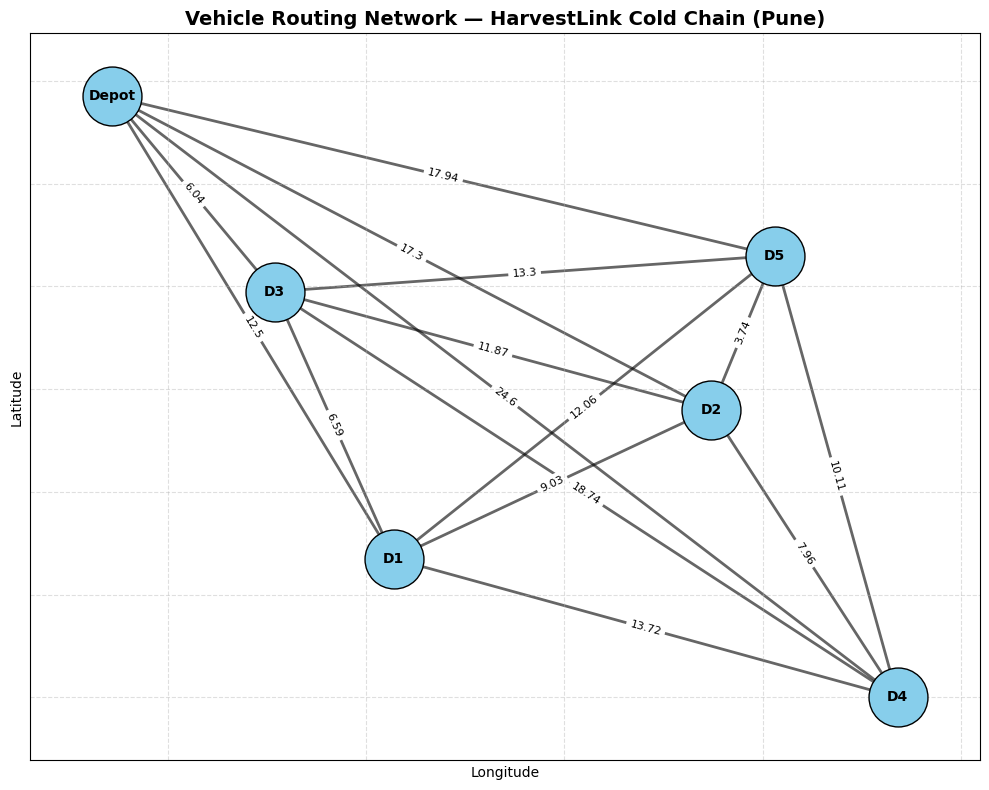

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from math import radians, sin, cos, sqrt, atan2

# -------------------------------
# 1. Define location data
# -------------------------------
data = {
    'Location_ID': ['Depot', 'D1', 'D2', 'D3', 'D4', 'D5'],
    'Location_Name': [
        'FreshCart Logistics Pvt. Ltd. Depot - Hinjewadi',
        'Kothrud Customer',
        'Koregaon Park Customer',
        'Baner Customer',
        'Hadapsar Customer',
        'Viman Nagar Customer'
    ],
    'Latitude': [18.597, 18.507, 18.536, 18.559, 18.48, 18.566],
    'Longitude': [73.736, 73.807, 73.887, 73.777, 73.934, 73.903]
}

df = pd.DataFrame(data)

# -------------------------------
# 2. Haversine function
# -------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius (km)
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

# -------------------------------
# 3. Compute pairwise distance matrix
# -------------------------------
edges = []
for i in range(len(df)):
    for j in range(i+1, len(df)):
        dist = haversine(df.loc[i, 'Latitude'], df.loc[i, 'Longitude'],
                         df.loc[j, 'Latitude'], df.loc[j, 'Longitude'])
        edges.append((df.loc[i, 'Location_ID'], df.loc[j, 'Location_ID'], round(dist, 2)))

# Convert to DataFrame (optional)
dist_df = pd.DataFrame(edges, columns=['From', 'To', 'Distance_km'])
print(dist_df)

# -------------------------------
# 4. Create Network Graph
# -------------------------------
G = nx.Graph()

# Add nodes and edges
for _, row in dist_df.iterrows():
    G.add_edge(row['From'], row['To'], weight=row['Distance_km'])

# -------------------------------
# 5. Node positions for visualization
# -------------------------------
# Scale latitude and longitude for display
pos = {row['Location_ID']: (row['Longitude'], row['Latitude']) for _, row in df.iterrows()}

# -------------------------------
# 6. Draw network graph
# -------------------------------
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1800, edgecolors='black')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Add distance labels to edges
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

plt.title("Vehicle Routing Network — HarvestLink Cold Chain (Pune)", fontsize=14, fontweight='bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



Best route (visiting all customers and returning to Depot):
Depot -> D3 -> D1 -> D4 -> D2 -> D5 -> Depot
Total straight-line distance (Haversine, km): 55.992 km


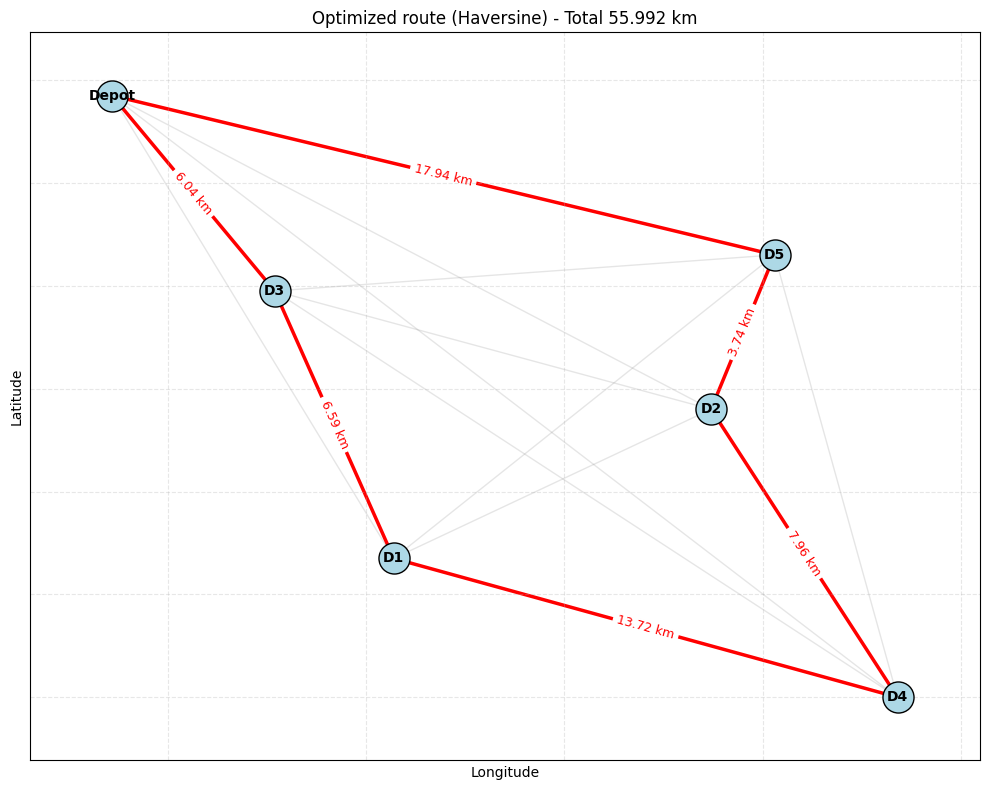


Files created successfully:
 - Distance matrix CSV: E:/Trimester 5/LAMM/distance_matrix_km.csv
 - Optimized route map (Folium HTML): E:/Trimester 5/LAMM/optimized_route.html
 - Optimized route image (PNG): E:/Trimester 5/LAMM/optimized_route.png


In [28]:
# ==========================================
# TSP Solver (Brute Force) + Visualization
# ==========================================

from math import radians, sin, cos, sqrt, atan2
import itertools
import pandas as pd
import folium
import os
import matplotlib.pyplot as plt
import networkx as nx

# Define nodes
nodes = [
    {"id": "Depot", "name": "FreshCart Depot - Hinjewadi", "lat": 18.597, "lon": 73.736},
    {"id": "D1", "name": "Kothrud Customer", "lat": 18.507, "lon": 73.807},
    {"id": "D2", "name": "Koregaon Park Customer", "lat": 18.536, "lon": 73.887},
    {"id": "D3", "name": "Baner Customer", "lat": 18.559, "lon": 73.777},
    {"id": "D4", "name": "Hadapsar Customer", "lat": 18.48,  "lon": 73.934},
    {"id": "D5", "name": "Viman Nagar Customer", "lat": 18.566, "lon": 73.903},
]

# Haversine distance (km)
def haversine(a, b):
    lat1, lon1 = a['lat'], a['lon']
    lat2, lon2 = b['lat'], b['lon']
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a_ = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a_), sqrt(1-a_))
    return R * c

# Build distance matrix
ids = [n['id'] for n in nodes]
node_map = {n['id']: n for n in nodes}
dist = {i: {} for i in ids}
for i in ids:
    for j in ids:
        dist[i][j] = round(haversine(node_map[i], node_map[j]), 4)

# Solve TSP by brute-force (Depot fixed start/end)
customers = ids[1:]
best_route = None
best_distance = float('inf')

for perm in itertools.permutations(customers):
    route = ['Depot'] + list(perm) + ['Depot']
    total = sum(dist[a][b] for a, b in zip(route[:-1], route[1:]))
    if total < best_distance:
        best_distance = total
        best_route = route

print("\nBest route (visiting all customers and returning to Depot):")
print(" -> ".join(best_route))
print(f"Total straight-line distance (Haversine, km): {best_distance:.3f} km")

# --- Create output directory automatically ---
output_dir = "E:/Trimester 5/LAMM"
os.makedirs(output_dir, exist_ok=True)

# Save distance matrix CSV
dist_matrix_df = pd.DataFrame(dist).T[ids]
csv_path = os.path.join(output_dir, "distance_matrix_km.csv")
dist_matrix_df.to_csv(csv_path, index=True)

# Create folium map
center_lat = sum([n['lat'] for n in nodes]) / len(nodes)
center_lon = sum([n['lon'] for n in nodes]) / len(nodes)
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add markers
for n in nodes:
    folium.Marker([n['lat'], n['lon']], popup=f"{n['id']}: {n['name']}", tooltip=n['id']).add_to(m)

# Draw optimized route
route_coords = [[node_map[n]['lat'], node_map[n]['lon']] for n in best_route]
folium.PolyLine(route_coords, color='red', weight=4, opacity=0.8,
                tooltip=f"Optimized route - {best_distance:.2f} km").add_to(m)

# Add numbered markers for route sequence
for idx, node_id in enumerate(best_route):
    n = node_map[node_id]
    folium.Marker(
        [n['lat'], n['lon']],
        icon=folium.DivIcon(
            icon_size=(150, 36),
            html=f'<div style="font-size:12px;color:black;background-color:white;'
                 f'padding:2px;border-radius:3px;">{idx}. {node_id}</div>'
        )
    ).add_to(m)

out_map = os.path.join(output_dir, "optimized_route.html")
m.save(out_map)

# --- Draw NetworkX diagram ---
G = nx.Graph()
for a in ids:
    G.add_node(a, pos=(node_map[a]['lon'], node_map[a]['lat']))
for a in ids:
    for b in ids:
        if a != b:
            G.add_edge(a, b, weight=dist[a][b])

pos = {n: (node_map[n]['lon'], node_map[n]['lat']) for n in ids}

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')

route_edges = list(zip(best_route[:-1], best_route[1:]))
nx.draw_networkx_edges(G, pos, edgelist=route_edges, edge_color='red', width=2.5)
edge_labels = {(u, v): f"{dist[u][v]:.2f} km" for u, v in route_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=9)

plt.title(f"Optimized route (Haversine) - Total {best_distance:.3f} km")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

png_path = os.path.join(output_dir, "optimized_route.png")
plt.savefig(png_path, dpi=200)
plt.show()

# Outputs
print("\nFiles created successfully:")
print(" - Distance matrix CSV:", csv_path)
print(" - Optimized route map (Folium HTML):", out_map)
print(" - Optimized route image (PNG):", png_path)


In [6]:
# ==========================================
# Vehicle Routing Optimization (Distance + Time)
# ==========================================
import pandas as pd
import numpy as np
import folium
import math
import os
from itertools import permutations

# -------------------------------
# Step 1: Define location dataset
# -------------------------------
locations = {
    "Depot": [18.597, 73.736],
    "D1": [18.507, 73.807],
    "D2": [18.536, 73.887],
    "D3": [18.559, 73.777],
    "D4": [18.480, 73.934],
    "D5": [18.566, 73.903]
}

ids = list(locations.keys())

# --------------------------------------------
# Step 2: Function to calculate Haversine distance
# --------------------------------------------
def haversine(coord1, coord2):
    R = 6371  # Radius of Earth (km)
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# --------------------------------------------
# Step 3: Compute distance matrix
# --------------------------------------------
dist = {}
for i in ids:
    dist[i] = {}
    for j in ids:
        if i == j:
            dist[i][j] = 0
        else:
            dist[i][j] = round(haversine(locations[i], locations[j]), 2)

dist_matrix_df = pd.DataFrame(dist).T[ids]

# --------------------------------------------
# Step 4: Save distance matrix safely
# --------------------------------------------
save_path = "distance_matrix_km.csv"
dist_matrix_df.to_csv(save_path, index=True)
print(f"✅ Distance matrix saved as: {save_path}")

# --------------------------------------------
# Step 5: Convert to time matrix (assuming avg speed 40 km/h)
# --------------------------------------------
speed_kmph = 40
time_matrix = dist_matrix_df / speed_kmph
time_matrix = time_matrix.round(3)  # time in hours

# Save time matrix as CSV
time_matrix.to_csv("travel_time_hours.csv")
print("✅ Travel time matrix saved as: travel_time_hours.csv")

# --------------------------------------------
# Step 6: Solve optimization (minimize travel time)
# --------------------------------------------
nodes = list(locations.keys())
depot = nodes[0]
customers = nodes[1:]

min_time = float('inf')
best_route = None

for perm in permutations(customers):
    route = [depot] + list(perm) + [depot]
    total_time = sum(time_matrix.loc[route[i], route[i+1]] for i in range(len(route)-1))
    if total_time < min_time:
        min_time = total_time
        best_route = route

min_dist = sum(dist[best_route[i]][best_route[i+1]] for i in range(len(best_route)-1))

print("\n🚚 Optimized Route (Min Travel Time):")
print(" -> ".join(best_route))
print(f"Total Distance: {round(min_dist, 2)} km")
print(f"Total Travel Time: {round(min_time*60, 2)} minutes (~{round(min_time, 2)} hours)")

# --------------------------------------------
# Step 7: Visualize optimized route using Folium
# --------------------------------------------
m = folium.Map(location=locations["Depot"], zoom_start=12)

# Add depot marker
folium.Marker(
    locations["Depot"],
    popup="Depot (Start/End)",
    icon=folium.Icon(color="red", icon="home")
).add_to(m)

# Add customer markers
for node, coord in locations.items():
    if node != "Depot":
        folium.Marker(coord, popup=node, icon=folium.Icon(color="blue")).add_to(m)

# Draw optimized route
route_coords = [locations[n] for n in best_route]
folium.PolyLine(route_coords, color="green", weight=4, opacity=0.8, popup="Optimized Route").add_to(m)

# Save route map
map_path = "optimized_route_time.html"
m.save(map_path)
print(f"✅ Route map saved as: {map_path}")

# --------------------------------------------
# Step 8: Summary Output
# --------------------------------------------
print("\n--- Summary ---")
print(f"Number of Locations: {len(ids)}")
print(f"Optimized Route: {' -> '.join(best_route)}")
print(f"Total Distance (km): {round(min_dist, 2)}")
print(f"Total Travel Time (minutes): {round(min_time*60, 2)}")


✅ Distance matrix saved as: distance_matrix_km.csv
✅ Travel time matrix saved as: travel_time_hours.csv

🚚 Optimized Route (Min Travel Time):
Depot -> D3 -> D1 -> D4 -> D2 -> D5 -> Depot
Total Distance: 55.99 km
Total Travel Time: 84.0 minutes (~1.4 hours)
✅ Route map saved as: optimized_route_time.html

--- Summary ---
Number of Locations: 6
Optimized Route: Depot -> D3 -> D1 -> D4 -> D2 -> D5 -> Depot
Total Distance (km): 55.99
Total Travel Time (minutes): 84.0


In [5]:
# ==========================================
# Multi-Vehicle CVRPTW Optimization (Distance, Capacity, Load Balance)
# ==========================================
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import pandas as pd
import numpy as np
import folium

# --------------------------------------------
# Step 1: Define input data
# --------------------------------------------
locations = {
    "Depot": [18.597, 73.736],
    "D1": [18.507, 73.807],
    "D2": [18.536, 73.887],
    "D3": [18.559, 73.777],
    "D4": [18.480, 73.934],
    "D5": [18.566, 73.903]
}

ids = list(locations.keys())

# Assign random realistic customer demands (units)
np.random.seed(42)
demands = {"Depot": 0, "D1": 45, "D2": 35, "D3": 50, "D4": 60, "D5": 40}

# --------------------------------------------
# Step 2: Define Haversine distance function
# --------------------------------------------
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Compute distance matrix
dist_matrix = []
for i in ids:
    row = []
    for j in ids:
        row.append(round(haversine(locations[i], locations[j]), 2))
    dist_matrix.append(row)

# --------------------------------------------
# Step 3: OR-Tools data model
# --------------------------------------------
data = {}
data["distance_matrix"] = dist_matrix
data["num_vehicles"] = 3
data["depot"] = 0
data["demands"] = [demands[i] for i in ids]
data["vehicle_capacities"] = [100, 100, 100]
data["time_windows"] = [(0, 600)] + [(60, 300)] * (len(ids)-1)  # depot open all day; customers 9:00–14:00

# --------------------------------------------
# Step 4: Create Routing Model
# --------------------------------------------
manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                       data["num_vehicles"], data["depot"])

routing = pywrapcp.RoutingModel(manager)

# Distance callback
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(data["distance_matrix"][from_node][to_node] * 1000)  # meters

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Capacity constraint
def demand_callback(from_index):
    from_node = manager.IndexToNode(from_index)
    return data["demands"][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # no slack
    data["vehicle_capacities"],
    True,
    "Capacity",
)

# Time dimension (approximate, assuming 40 km/h)
speed = 40
def travel_time_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    distance_km = data["distance_matrix"][from_node][to_node]
    return int((distance_km / speed) * 60)  # minutes

time_callback_index = routing.RegisterTransitCallback(travel_time_callback)
routing.AddDimension(
    time_callback_index,
    30,  # waiting slack
    600,  # max time window (10 hours)
    False,
    "Time",
)

time_dimension = routing.GetDimensionOrDie("Time")

# Add time windows
for location_idx, time_window in enumerate(data["time_windows"]):
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

# --------------------------------------------
# Step 5: Search parameters
# --------------------------------------------
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.time_limit.FromSeconds(10)
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)

# --------------------------------------------
# Step 6: Solve
# --------------------------------------------
solution = routing.SolveWithParameters(search_parameters)

# --------------------------------------------
# Step 7: Extract results
# --------------------------------------------
if solution:
    total_distance = 0
    vehicle_loads = []
    print("\n🚚 Optimized Multi-Vehicle Routes:")
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Vehicle {vehicle_id + 1} route:\n"
        route_distance = 0
        route_load = 0
        route_points = []

        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            route_points.append(locations[ids[node_index]])
            next_index = solution.Value(routing.NextVar(index))
            route_distance += data["distance_matrix"][node_index][manager.IndexToNode(next_index)]
            index = next_index

        total_distance += route_distance
        vehicle_loads.append(route_load)
        route_points.append(locations["Depot"])
        plan_output += f"  Load: {route_load} units | Distance: {round(route_distance,2)} km\n"
        print(plan_output)

    print(f"\nTotal Distance: {round(total_distance, 2)} km")
    print(f"Vehicle Loads: {vehicle_loads}")
    print(f"Average Load: {np.mean(vehicle_loads):.1f} units")

    # --------------------------------------------
    # Step 8: Visualization
    # --------------------------------------------
    m = folium.Map(location=locations["Depot"], zoom_start=12)
    folium.Marker(locations["Depot"], popup="Depot", icon=folium.Icon(color="red")).add_to(m)
    colors = ["blue", "green", "orange"]

    for i, vehicle_id in enumerate(range(data["num_vehicles"])):
        route_points = []
        index = routing.Start(vehicle_id)
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_points.append(locations[ids[node_index]])
            next_index = solution.Value(routing.NextVar(index))
            index = next_index
        route_points.append(locations["Depot"])
        folium.PolyLine(route_points, color=colors[i % len(colors)], weight=5,
                        opacity=0.8, popup=f"Vehicle {i+1}").add_to(m)

    m.save("CVRPTW_routes.html")
    print("✅ Route map saved as: CVRPTW_routes.html")

else:
    print("❌ No feasible solution found.")



🚚 Optimized Multi-Vehicle Routes:
Vehicle 1 route:
  Load: 100 units | Distance: 52.65 km

Vehicle 2 route:
  Load: 80 units | Distance: 38.83 km

Vehicle 3 route:
  Load: 50 units | Distance: 12.08 km


Total Distance: 103.56 km
Vehicle Loads: [100, 80, 50]
Average Load: 76.7 units
✅ Route map saved as: CVRPTW_routes.html


In [1]:
# ==========================================
# Multi-Vehicle Cold-Chain Route Optimization (CVRP + Time)
# ==========================================

# ---- Install OR-Tools if not installed ----
try:
    from ortools.constraint_solver import pywrapcp, routing_enums_pb2
except ModuleNotFoundError:
    import os
    os.system("pip install ortools folium")
    from ortools.constraint_solver import pywrapcp, routing_enums_pb2

import pandas as pd
import numpy as np
import folium
import math
import os

# ------------------------------------------------------
# 1. INPUT DATA (Depot + Customers + Vehicle Parameters)
# ------------------------------------------------------
data_points = {
    "Location_ID": ["Depot", "D1", "D2", "D3", "D4", "D5"],
    "Latitude": [18.597, 18.507, 18.536, 18.559, 18.480, 18.566],
    "Longitude": [73.736, 73.807, 73.887, 73.777, 73.934, 73.903],
    "Demand": [0, 20, 30, 10, 25, 15],   # realistic demand in units
}

df = pd.DataFrame(data_points)

# Define the number of vehicles as a variable
num_vehicles = 3  # change this to 2, 4, etc. anytime
vehicle_capacity = 100  # units per vehicle
avg_speed_kmph = 30     # to convert distance to time

# ---------------------------------
# 2. DISTANCE + TIME MATRIX (Haversine)
# ---------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

dist_matrix = []
for i in range(len(df)):
    row = []
    for j in range(len(df)):
        row.append(haversine(df.Latitude[i], df.Longitude[i],
                             df.Latitude[j], df.Longitude[j]))
    dist_matrix.append(row)

# Convert to time matrix (in minutes)
time_matrix = [[(dist / avg_speed_kmph) * 60 for dist in row] for row in dist_matrix]

# --------------------------
# 3. BUILD OR-TOOLS DATA MODEL
# --------------------------
data = {
    'distance_matrix': dist_matrix,
    'time_matrix': time_matrix,
    'num_vehicles': num_vehicles,
    'vehicle_capacities': [vehicle_capacity] * num_vehicles,
    'demands': df['Demand'].tolist(),
    'depot': 0
}

# --------------------------
# 4. DEFINE ROUTING MODEL
# --------------------------
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

# Distance callback
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(data['distance_matrix'][from_node][to_node] * 1000)  # meters

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Capacity constraint
def demand_callback(from_index):
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index, 0, data['vehicle_capacities'], True, "Capacity")

# --------------------------
# 5. SEARCH PARAMETERS
# --------------------------
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
search_parameters.time_limit.seconds = 5

# --------------------------
# 6. SOLVE AND EXTRACT RESULTS
# --------------------------
solution = routing.SolveWithParameters(search_parameters)

if not solution:
    print("❌ No feasible solution found.")
else:
    print("✅ Optimized routes found!\n")

    total_distance = 0
    route_details = []

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route_distance = 0
        route_load = 0
        route_nodes = ["Depot"]

        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id) / 1000
            route_nodes.append(df['Location_ID'][manager.IndexToNode(index)])

        total_distance += route_distance
        route_details.append({
            "Vehicle": f"V{vehicle_id + 1}",
            "Route": " → ".join(route_nodes),
            "Distance_km": round(route_distance, 2),
            "Load_units": route_load
        })

    result_df = pd.DataFrame(route_details)
    print(result_df)

    # --------------------------
    # 7. FOLIUM MAP VISUALIZATION
    # --------------------------
    depot_coords = [df.Latitude[0], df.Longitude[0]]
    m = folium.Map(location=depot_coords, zoom_start=12)
    folium.Marker(depot_coords, popup="Depot", icon=folium.Icon(color='red')).add_to(m)

    colors = ['blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue']

    for i, route in enumerate(route_details):
        route_nodes = route["Route"].split(" → ")
        coords = [(df.loc[df.Location_ID == node, 'Latitude'].values[0],
                   df.loc[df.Location_ID == node, 'Longitude'].values[0]) for node in route_nodes]

        folium.PolyLine(coords, color=colors[i % len(colors)],
                        weight=4, opacity=0.8, popup=f"Vehicle {i+1}").add_to(m)

        for point in coords[1:-1]:
            folium.CircleMarker(point, radius=4, color='black', fill=True).add_to(m)

    os.makedirs("results", exist_ok=True)
    result_df.to_csv("results/optimized_routes.csv", index=False)
    m.save("results/optimized_multivehicle_routes.html")

    print(f"\nTotal distance traveled by all vehicles: {round(total_distance,2)} km")
    print("✅ Results saved in folder: results/")


✅ Optimized routes found!

  Vehicle                                   Route  Distance_km  Load_units
0      V1                           Depot → Depot         0.00           0
1      V2                           Depot → Depot         0.00           0
2      V3  Depot → D5 → D2 → D4 → D1 → D3 → Depot        55.99         100

Total distance traveled by all vehicles: 55.99 km
✅ Results saved in folder: results/


In [22]:
# ==========================================
# MAP VISUALIZATION OF OPTIMIZED VEHICLE ROUTES
# ==========================================

import folium
import random

# --- Step 1: Define node coordinates (replace or extend as needed)
locations = {
    'Depot': [18.597, 73.736],
    'D1': [18.507, 73.807],
    'D2': [18.536, 73.887],
    'D3': [18.559, 73.777],
    'D4': [18.480, 73.934],
    'D5': [18.566, 73.903],
}

# --- Step 2: Example optimized routes (replace with your actual output)
# Each vehicle route is a list of node IDs (starting/ending at Depot)
routes = {
    'Vehicle 1': ['Depot', 'D1', 'D3', 'Depot'],
    'Vehicle 2': ['Depot', 'D2', 'D5', 'D4', 'Depot']
}

# --- Step 3: Create the folium map centered near the depot
m = folium.Map(location=locations['Depot'], zoom_start=12)

# --- Step 4: Define colors for routes
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue', 'darkgreen']
color_map = {veh: colors[i % len(colors)] for i, veh in enumerate(routes)}

# --- Step 5: Add routes and markers
for veh, route in routes.items():
    # Draw route line
    coords = [locations[node] for node in route]
    folium.PolyLine(
        coords,
        color=color_map[veh],
        weight=5,
        opacity=0.8,
        tooltip=f"{veh} Route"
    ).add_to(m)

    # Add markers for each stop
    for node in route:
        if node == 'Depot':
            folium.Marker(
                locations[node],
                popup=f"{node} (Depot)",
                icon=folium.Icon(color='black', icon='home')
            ).add_to(m)
        else:
            folium.Marker(
                locations[node],
                popup=f"{node}",
                icon=folium.Icon(color=color_map[veh], icon='truck')
            ).add_to(m)

# --- Step 6: Save map as HTML
m.save("optimized_routes_map.html")

# --- Step 7 (Optional): Display in Jupyter
m


In [25]:
# ==========================================
# MAP VISUALIZATION: 3 TRUCK ROUTES (DIFFERENT COLORS)
# ==========================================

import folium

# --- Step 1: Define node coordinates ---
locations = {
    'Depot': [18.597, 73.736],
    'D1': [18.507, 73.807],
    'D2': [18.536, 73.887],
    'D3': [18.559, 73.777],
    'D4': [18.480, 73.934],
    'D5': [18.566, 73.903],
    'D6': [18.52, 73.85],    # Added extra nodes for illustration
    'D7': [18.49, 73.89],
}

# --- Step 2: Define routes for 3 trucks (example) ---
routes = {
    'Truck 1': ['Depot', 'D1', 'D3', 'D6', 'Depot'],
    'Truck 2': ['Depot', 'D2', 'D5', 'Depot'],
    'Truck 3': ['Depot', 'D4', 'D7', 'Depot']
}

# --- Step 3: Create base map centered near the depot ---
m = folium.Map(location=locations['Depot'], zoom_start=12)

# --- Step 4: Define distinct colors for each truck ---
colors = ['red', 'blue', 'green']
color_map = {veh: colors[i % len(colors)] for i, veh in enumerate(routes)}

# --- Step 5: Plot each truck route ---
for truck, route in routes.items():
    coords = [locations[stop] for stop in route]

    # Draw line for route
    folium.PolyLine(
        coords,
        color=color_map[truck],
        weight=5,
        opacity=0.8,
        tooltip=f"{truck} Route"
    ).add_to(m)

    # Mark each stop
    for stop in route:
        if stop == 'Depot':
            folium.Marker(
                locations[stop],
                popup=f"{stop} (Depot)",
                icon=folium.Icon(color='black', icon='home')
            ).add_to(m)
        else:
            folium.Marker(
                locations[stop],
                popup=f"{stop} ({truck})",
                icon=folium.Icon(color=color_map[truck], icon='truck')
            ).add_to(m)

# --- Step 6: Save and display map ---
m.save("three_truck_routes_map.html")
m
